# Multi GS Classifier using Random Forests

### Attempt to classifier GS events with a Random Forest

### Labels: 0 = noGS, 1 = GSb , 2 = GSbb

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
df = pd.read_csv('/Users/rohan/research/gs_classifier/output_multigs.csv')
print(df.shape)

feats = df.iloc[:,0:12]
y = df.isgs

(164656, 13)


In [15]:
print(feats.shape)
feats.head(5)

(164656, 12)


,weight,dr_bb,bb_pt,bb_m,jet1_csv,jet1_pt,jet1_eta,jet1_phi,jet2_csv,jet2_pt,jet2_eta,jet2_phi
0,0.068587,0.947933,806.513000,418.969666,0.970258,469.232178,-1.552434,0.988524,0.906826,340.613373,-0.622500,1.172366
1,0.065783,1.710818,345.106720,202.336594,0.993821,47.740227,1.110587,-1.902524,0.958397,346.806488,0.763946,-0.227192
2,0.069150,0.821434,699.727417,307.803986,0.996421,344.196381,0.981522,-0.860860,0.901411,418.045929,1.034307,-0.041124
3,0.069805,1.968648,235.376617,302.447571,0.987000,153.347351,0.517652,0.096551,0.862928,140.702484,-0.972188,1.383389
4,0.068559,1.061551,743.231018,418.841614,0.907696,374.111206,0.631812,1.520363,0.853196,370.016937,-0.425185,1.618583


In [16]:
print(y.shape)
y.head(5)

(164656,)


0    2
1    2
2    0
3    1
4    0
Name: isgs, dtype: int64

## Compute a baseline metric
### Here using a simple cut on the dr_bb distribution
#### In previous iteration of the RPV search we used dr_bb < 1.6 to classify gs

In [17]:
print("# of GS predicted as GS:         {}").format(
    round(float(sum(df[df.dr_bb<1.6].weight*(df[df.dr_bb<1.6].isgs>0))),3))
print("# of GS not predicted as GS:     {}").format(
    round(float(sum(df[df.dr_bb>=1.6].weight*(df[df.dr_bb>=1.6].isgs>0))),3))
print("# of not GS predicted as GS:     {}").format(
    round(float(sum(df[df.dr_bb<1.6].weight*(df[df.dr_bb<1.6].isgs==0))),3))
print("# of not GS predicted as not GS: {}").format(
    round(float(sum(df[df.dr_bb>=1.6].weight*(df[df.dr_bb>=1.6].isgs==0))),3))

# of GS predicted as GS:         345.099
# of GS not predicted as GS:     313.982
# of not GS predicted as GS:     314.699
# of not GS predicted as not GS: 417.843


In [18]:
cm_cut = np.ndarray((2,2), buffer=np.array([345.099, 313.982, 314.699, 417.843]))
print("Accuracy: {}").format((cm_cut.trace()/cm_cut.sum()).round(3))
print("Confusion matrix:")
print(cm_cut)

print("\n Normalized confusion matrix:")
print((cm_cut/cm_cut.sum(axis=1)[:, np.newaxis]).round(3))

Accuracy: 0.548
Confusion matrix:
[[ 345.099  313.982]
 [ 314.699  417.843]]

 Normalized confusion matrix:
[[ 0.524  0.476]
 [ 0.43   0.57 ]]


## Split data in train, test, and validation sets

In [19]:
from sklearn.model_selection import train_test_split
feats_train, feats_test, y_train, y_test = train_test_split(feats, y, train_size=0.6, random_state=354)
feats_test, feats_val, y_test, y_val = train_test_split(feats_test, y_test, train_size=0.5, random_state=3874)

weights_train, X_train = feats_train.weight, feats_train.iloc[:,1:12]
weights_test , X_test  = feats_test.weight ,  feats_test.iloc[:,1:12]
weights_val  , X_val   = feats_val.weight  ,  feats_val.iloc[:,1:12]

In [20]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(98793, 11)
(32931, 11)
(32932, 11)


In [28]:
from sklearn.ensemble import RandomForestClassifier

# Configure RF
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train, sample_weight=weights_train.values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
# Make predictions
pred_train = rf.predict(X_train)
pred_test = rf.predict(X_test)

In [31]:
# Collapse confusion matrix into noGS vs GS
def get_cm_gs(mat, norm=False):
    if mat.shape != (3,3): print("Matrix shape must be (3,3)")
        
    cm_gs = mat
    cm_gs[1,:]+=cm_gs[2,:]
    cm_gs[:,1]+=cm_gs[:,2]
    cm_gs = cm_gs[:2,:2]
    
    if norm:
        return(cm_gs/cm_gs.sum(axis=1)[:, np.newaxis])
    else:
        return(cm_gs)

In [30]:
from sklearn.metrics import confusion_matrix

#Print results
# Train accuracy
cm_train = confusion_matrix(y_train, pred_train, sample_weight=weights_train.values)
print("Train Multi-GS Accuracy: {}").format((cm_train.trace()/cm_train.sum()).round(3))
print(cm_train/cm_train.sum(axis=1)[:, np.newaxis])
print("\n")

cm_gs_train = get_cm_gs(cm_train)
print("Train GS Accuracy: {}").format((cm_gs_train.trace()/cm_gs_train.sum()).round(3))
print(cm_gs_train/cm_gs_train.sum(axis=1)[:, np.newaxis])
print("\n")

# Test accuracy
cm_test = confusion_matrix(y_test, pred_test, sample_weight=weights_test.values)
print("Test Accuracy: {}").format((cm_test.trace()/cm_test.sum()).round(3))
print(cm_test/cm_test.sum(axis=1)[:, np.newaxis])
print("\n")

cm_gs_test = get_cm_gs(cm_test)
print("Train GS Accuracy: {}").format((cm_gs_test.trace()/cm_gs_test.sum()).round(3))
print(cm_gs_test/cm_gs_test.sum(axis=1)[:, np.newaxis])

Train Multi-GS Accuracy: 1.0
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


Train GS Accuracy: 1.0
[[ 1.  0.]
 [ 0.  1.]]


Test Accuracy: 0.579
[[ 0.73815058  0.17199716  0.08985226]
 [ 0.54196812  0.36999509  0.08803678]
 [ 0.40908304  0.11057501  0.48034196]]


Train GS Accuracy: 0.625
[[ 0.73815058  0.26184942]
 [ 0.49749278  0.50250722]]


### Now regularize

In [142]:
from sklearn.model_selection import GridSearchCV

rf_grid = RandomForestClassifier()

params = {'max_depth' : range(1,5),
          'min_impurity_split' : range(0,30,5),
          'criterion' : ['gini','entropy'],
          'n_estimators' : [100],
          'n_jobs' : [2]
         }

grid_search = GridSearchCV(estimator=rf_grid,
                           param_grid=params)


In [33]:
rf_grids = []
for ix, depth in enumerate(range(2,17,2)):
    for iy, impurity in enumerate(np.arange(0,0.4,0.1)):
    
        print("({}, {}): DEPTH = {}, IMPURITY = {}").format(ix, iy,depth,impurity)

        rf_grid = RandomForestClassifier(n_estimators=500, n_jobs=3, max_depth=depth, min_impurity_split=impurity)
        rf_grid.fit(X_train, y_train, sample_weight=weights_train.values)

        rf_grids.append(rf_grid)
        
        # Print results
        # Train accuracy
#        cm_train = confusion_matrix(y_train, rf_grid.predict(X_train), sample_weight=weights_train.values)
#        print("Train Multi-GS Accuracy: {}").format((cm_train.trace()/cm_train.sum()).round(3))
#        print(cm_train/cm_train.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_train = get_cm_gs(cm_train)
        print("Train GS Accuracy: {}").format((cm_gs_train.trace()/cm_gs_train.sum()).round(3))
#        print(cm_gs_train/cm_gs_train.sum(axis=1)[:, np.newaxis])
#        print("\n")

        # Test accuracy
        cm_test = confusion_matrix(y_test, rf_grid.predict(X_test), sample_weight=weights_test.values)
#        print("Test Accuracy: {}").format((cm_test.trace()/cm_test.sum()).round(3))
#        print(cm_test/cm_test.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_test = get_cm_gs(cm_test)
        print("Test GS Accuracy: {}").format((cm_gs_test.trace()/cm_gs_test.sum()).round(3))
        print(cm_gs_test/cm_gs_test.sum(axis=1)[:, np.newaxis])
        print('\n')
        
        # Validation accuracy
        cm_val = confusion_matrix(y_val, rf_grid.predict(X_val), sample_weight=weights_val.values)
#        print("Test Accuracy: {}").format((cm_test.trace()/cm_test.sum()).round(3))
#        print(cm_test/cm_test.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_val = get_cm_gs(cm_val)
        print("Validation GS Accuracy: {}").format((cm_gs_val.trace()/cm_gs_val.sum()).round(3))
        print(cm_gs_val/cm_gs_val.sum(axis=1)[:, np.newaxis])
        print('\n')

(0, 0): DEPTH = 2, IMPURITY = 0.0
Train GS Accuracy: 1.0
Test GS Accuracy: 0.52
[[ 1.  0.]
 [ 1.  0.]]


Validation GS Accuracy: 0.532
[[ 1.  0.]
 [ 1.  0.]]


(0, 1): DEPTH = 2, IMPURITY = 0.1
Train GS Accuracy: 1.0
Test GS Accuracy: 0.52
[[ 1.  0.]
 [ 1.  0.]]


Validation GS Accuracy: 0.532
[[ 1.  0.]
 [ 1.  0.]]


(0, 2): DEPTH = 2, IMPURITY = 0.2
Train GS Accuracy: 1.0
Test GS Accuracy: 0.52
[[ 1.  0.]
 [ 1.  0.]]


Validation GS Accuracy: 0.532
[[ 1.  0.]
 [ 1.  0.]]


(0, 3): DEPTH = 2, IMPURITY = 0.3
Train GS Accuracy: 1.0
Test GS Accuracy: 0.52
[[ 1.  0.]
 [ 1.  0.]]


Validation GS Accuracy: 0.532
[[ 1.  0.]
 [ 1.  0.]]


(1, 0): DEPTH = 4, IMPURITY = 0.0
Train GS Accuracy: 1.0
Test GS Accuracy: 0.593
[[ 0.869928    0.130072  ]
 [ 0.70665199  0.29334801]]


Validation GS Accuracy: 0.594
[[ 0.87043895  0.12956105]
 [ 0.71987133  0.28012867]]


(1, 1): DEPTH = 4, IMPURITY = 0.1
Train GS Accuracy: 1.0
Test GS Accuracy: 0.589
[[ 0.87655213  0.12344787]
 [ 0.72223608  0.27776392]]

In [35]:
## EXTEND THE DEPTH A LITTLE MORE
for ix, depth in enumerate(range(18,22,2)):
    for iy, impurity in enumerate(np.arange(0,0.4,0.1)):
    
        print("({}, {}): DEPTH = {}, IMPURITY = {}").format(ix, iy,depth,impurity)

        rf_grid = RandomForestClassifier(n_estimators=500, n_jobs=3, max_depth=depth, min_impurity_split=impurity)
        rf_grid.fit(X_train, y_train, sample_weight=weights_train.values)

        rf_grids.append(rf_grid)
        
        # Print results
        # Train accuracy
#        cm_train = confusion_matrix(y_train, rf_grid.predict(X_train), sample_weight=weights_train.values)
#        print("Train Multi-GS Accuracy: {}").format((cm_train.trace()/cm_train.sum()).round(3))
#        print(cm_train/cm_train.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_train = get_cm_gs(cm_train)
        print("Train GS Accuracy: {}").format((cm_gs_train.trace()/cm_gs_train.sum()).round(3))
#        print(cm_gs_train/cm_gs_train.sum(axis=1)[:, np.newaxis])
#        print("\n")

        # Test accuracy
        cm_test = confusion_matrix(y_test, rf_grid.predict(X_test), sample_weight=weights_test.values)
#        print("Test Accuracy: {}").format((cm_test.trace()/cm_test.sum()).round(3))
#        print(cm_test/cm_test.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_test = get_cm_gs(cm_test)
        print("Test GS Accuracy: {}").format((cm_gs_test.trace()/cm_gs_test.sum()).round(3))
        print(cm_gs_test/cm_gs_test.sum(axis=1)[:, np.newaxis])
        print('\n')
        
        # Validation accuracy
        cm_val = confusion_matrix(y_val, rf_grid.predict(X_val), sample_weight=weights_val.values)
#        print("Test Accuracy: {}").format((cm_test.trace()/cm_test.sum()).round(3))
#        print(cm_test/cm_test.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_val = get_cm_gs(cm_val)
        print("Validation GS Accuracy: {}").format((cm_gs_val.trace()/cm_gs_val.sum()).round(3))
        print(cm_gs_val/cm_gs_val.sum(axis=1)[:, np.newaxis])
        print('\n')

(0, 0): DEPTH = 18, IMPURITY = 0.0
Train GS Accuracy: 1.0
Test GS Accuracy: 0.631
[[ 0.74939913  0.25060087]
 [ 0.49644588  0.50355412]]


Validation GS Accuracy: 0.632
[[ 0.7559052   0.2440948 ]
 [ 0.50763208  0.49236792]]


(0, 1): DEPTH = 18, IMPURITY = 0.1
Train GS Accuracy: 1.0
Test GS Accuracy: 0.631
[[ 0.75179768  0.24820232]
 [ 0.49953412  0.50046588]]


Validation GS Accuracy: 0.631
[[ 0.75625755  0.24374245]
 [ 0.51213257  0.48786743]]


(0, 2): DEPTH = 18, IMPURITY = 0.2
Train GS Accuracy: 1.0
Test GS Accuracy: 0.63
[[ 0.75499673  0.24500327]
 [ 0.50492198  0.49507802]]


Validation GS Accuracy: 0.633
[[ 0.76552016  0.23447984]
 [ 0.51711549  0.48288451]]


(0, 3): DEPTH = 18, IMPURITY = 0.3
Train GS Accuracy: 1.0
Test GS Accuracy: 0.63
[[ 0.75800723  0.24199277]
 [ 0.50861512  0.49138488]]


Validation GS Accuracy: 0.632
[[ 0.76465228  0.23534772]
 [ 0.51876108  0.48123892]]


(1, 0): DEPTH = 20, IMPURITY = 0.0
Train GS Accuracy: 1.0
Test GS Accuracy: 0.631
[[ 0.74451936  0

### Conclusion

#### Using a random forest did not improve on the decision tree.
#### Random Forests are beneficial for two reasons 1) They reduce overfitting and 2) They force the trees to learn other secondary variables
#### But the original decision tree 1) was not overfitting  and 2) there are really only a few (non-correlated) variables that discriminate, i.e. dr_bb/bb_m, jet1_csv, and jet2_csv

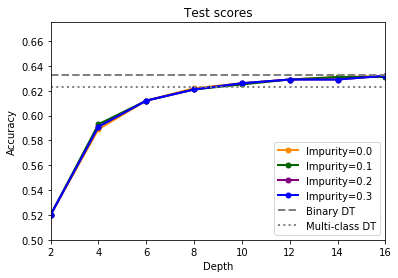

In [34]:
## scores split by impurity
imp0 = [0.52, 0.589, 0.612, 0.622, 0.626, 0.629, 0.631, 0.632]
imp1 = [0.52, 0.593, 0.612, 0.621, 0.625, 0.629, 0.631, 0.631]
imp2 = [0.52, 0.591, 0.612, 0.621, 0.626, 0.629, 0.629, 0.632]
imp3 = [0.52, 0.590, 0.612, 0.620, 0.625, 0.629, 0.628, 0.631]

# Plot train/test scores as a function of depth
plt.plot(range(2,18,2), imp0, color='darkorange', label = 'Impurity=0.0', lw=2, marker='.', ms=10)
plt.plot(range(2,18,2), imp1, color='darkgreen', label = 'Impurity=0.1', lw=2, marker='.', ms=10)
plt.plot(range(2,18,2), imp2, color='purple', label = 'Impurity=0.2', lw=2, marker='.', ms=10)
plt.plot(range(2,18,2), imp2, color='blue', label = 'Impurity=0.3', lw=2, marker='.', ms=10)
plt.plot([2,16],[0.633,0.633], color='grey', lw = 2, linestyle='--', label='Binary DT')
plt.plot([2,16],[0.623,0.623], color='grey', lw = 2, linestyle=':', label='Multi-class DT')
plt.xlim([2,16])
plt.ylim([0.5, 0.675])
plt.title('Test scores')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Try to improve RF by removing useless variables

### Drop jet phis and etas

In [40]:
var_drop = ['jet1_phi','jet1_eta','jet2_phi','jet2_eta']
df.drop(var_drop, axis=1).head(5)

,weight,dr_bb,bb_pt,bb_m,jet1_csv,jet1_pt,jet2_csv,jet2_pt,isgs
0,0.068587,0.947933,806.513000,418.969666,0.970258,469.232178,0.906826,340.613373,2
1,0.065783,1.710818,345.106720,202.336594,0.993821,47.740227,0.958397,346.806488,2
2,0.069150,0.821434,699.727417,307.803986,0.996421,344.196381,0.901411,418.045929,0
3,0.069805,1.968648,235.376617,302.447571,0.987000,153.347351,0.862928,140.702484,1
4,0.068559,1.061551,743.231018,418.841614,0.907696,374.111206,0.853196,370.016937,0


In [42]:
X_train_dropped = feats_train.iloc[:,1:12].drop(var_drop,1)
X_test_dropped  = feats_test.iloc[:,1:12].drop(var_drop,1)
X_val_dropped   = feats_val.iloc[:,1:12].drop(var_drop,1)

In [44]:
print(X_train_dropped.shape)
print(X_test_dropped.shape)
print(X_val_dropped.shape)

(98793, 7)
(32931, 7)
(32932, 7)


In [45]:
rf_grids_dropped = []
for ix, depth in enumerate(range(2,17,2)):
    for iy, impurity in enumerate(np.arange(0,0.4,0.1)):
    
        print("({}, {}): DEPTH = {}, IMPURITY = {}").format(ix, iy,depth,impurity)

        rf_grid = RandomForestClassifier(n_estimators=500, n_jobs=3, max_depth=depth, min_impurity_split=impurity)
        rf_grid.fit(X_train_dropped, y_train, sample_weight=weights_train.values)

        rf_grids_dropped.append(rf_grid)
        
        # Print results
        # Train accuracy
#        cm_train = confusion_matrix(y_train, rf_grid.predict(X_train_dropped), sample_weight=weights_train.values)
#        print("Train Multi-GS Accuracy: {}").format((cm_train.trace()/cm_train.sum()).round(3))
#        print(cm_train/cm_train.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_train = get_cm_gs(cm_train)
        print("Train GS Accuracy: {}").format((cm_gs_train.trace()/cm_gs_train.sum()).round(3))
#        print(cm_gs_train/cm_gs_train.sum(axis=1)[:, np.newaxis])
#        print("\n")

        # Test accuracy
        cm_test = confusion_matrix(y_test, rf_grid.predict(X_test_dropped), sample_weight=weights_test.values)
#        print("Test Accuracy: {}").format((cm_test.trace()/cm_test.sum()).round(3))
#        print(cm_test/cm_test.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_test = get_cm_gs(cm_test)
        print("Test GS Accuracy: {}").format((cm_gs_test.trace()/cm_gs_test.sum()).round(3))
        print(cm_gs_test/cm_gs_test.sum(axis=1)[:, np.newaxis])
        print('\n')
        
        # Validation accuracy
        cm_val = confusion_matrix(y_val, rf_grid.predict(X_val_dropped), sample_weight=weights_val.values)
#        print("Test Accuracy: {}").format((cm_test.trace()/cm_test.sum()).round(3))
#        print(cm_test/cm_test.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_val = get_cm_gs(cm_val)
        print("Validation GS Accuracy: {}").format((cm_gs_val.trace()/cm_gs_val.sum()).round(3))
        print(cm_gs_val/cm_gs_val.sum(axis=1)[:, np.newaxis])
        print('\n')

(0, 0): DEPTH = 2, IMPURITY = 0.0
Train GS Accuracy: 1.0
Test GS Accuracy: 0.52
[[ 1.  0.]
 [ 1.  0.]]


Validation GS Accuracy: 0.532
[[ 1.  0.]
 [ 1.  0.]]


(0, 1): DEPTH = 2, IMPURITY = 0.1
Train GS Accuracy: 1.0
Test GS Accuracy: 0.52
[[ 1.  0.]
 [ 1.  0.]]


Validation GS Accuracy: 0.532
[[ 1.  0.]
 [ 1.  0.]]


(0, 2): DEPTH = 2, IMPURITY = 0.2
Train GS Accuracy: 1.0
Test GS Accuracy: 0.52
[[ 1.  0.]
 [ 1.  0.]]


Validation GS Accuracy: 0.532
[[ 1.  0.]
 [ 1.  0.]]


(0, 3): DEPTH = 2, IMPURITY = 0.3
Train GS Accuracy: 1.0
Test GS Accuracy: 0.52
[[ 1.  0.]
 [ 1.  0.]]


Validation GS Accuracy: 0.532
[[ 1.  0.]
 [ 1.  0.]]


(1, 0): DEPTH = 4, IMPURITY = 0.0
Train GS Accuracy: 1.0
Test GS Accuracy: 0.599
[[ 0.84839351  0.15160649]
 [ 0.67057268  0.32942732]]


Validation GS Accuracy: 0.597
[[ 0.84706918  0.15293082]
 [ 0.68775987  0.31224013]]


(1, 1): DEPTH = 4, IMPURITY = 0.1
Train GS Accuracy: 1.0
Test GS Accuracy: 0.594
[[ 0.85659944  0.14340056]
 [ 0.6899091   0.3100909 ]]

### Try with max_features=3

In [47]:
for ix, depth in enumerate(range(2,17,2)):
    for iy, impurity in enumerate(np.arange(0,0.4,0.1)):
    
        print("({}, {}): DEPTH = {}, IMPURITY = {}").format(ix, iy,depth,impurity)

        rf_grid = RandomForestClassifier(n_estimators=500, n_jobs=3, max_depth=depth, min_impurity_split=impurity, max_features=3)
        rf_grid.fit(X_train_dropped, y_train, sample_weight=weights_train.values)

        rf_grids_dropped.append(rf_grid)
        
        # Print results
        # Train accuracy
#        cm_train = confusion_matrix(y_train, rf_grid.predict(X_train_dropped), sample_weight=weights_train.values)
#        print("Train Multi-GS Accuracy: {}").format((cm_train.trace()/cm_train.sum()).round(3))
#        print(cm_train/cm_train.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_train = get_cm_gs(cm_train)
        print("Train GS Accuracy: {}").format((cm_gs_train.trace()/cm_gs_train.sum()).round(3))
#        print(cm_gs_train/cm_gs_train.sum(axis=1)[:, np.newaxis])
#        print("\n")

        # Test accuracy
        cm_test = confusion_matrix(y_test, rf_grid.predict(X_test_dropped), sample_weight=weights_test.values)
#        print("Test Accuracy: {}").format((cm_test.trace()/cm_test.sum()).round(3))
#        print(cm_test/cm_test.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_test = get_cm_gs(cm_test)
        print("Test GS Accuracy: {}").format((cm_gs_test.trace()/cm_gs_test.sum()).round(3))
        print(cm_gs_test/cm_gs_test.sum(axis=1)[:, np.newaxis])
        print('\n')
        
        # Validation accuracy
        cm_val = confusion_matrix(y_val, rf_grid.predict(X_val_dropped), sample_weight=weights_val.values)
#        print("Test Accuracy: {}").format((cm_test.trace()/cm_test.sum()).round(3))
#        print(cm_test/cm_test.sum(axis=1)[:, np.newaxis])
#        print("\n")

        cm_gs_val = get_cm_gs(cm_val)
        print("Validation GS Accuracy: {}").format((cm_gs_val.trace()/cm_gs_val.sum()).round(3))
        print(cm_gs_val/cm_gs_val.sum(axis=1)[:, np.newaxis])
        print('\n')

(0, 0): DEPTH = 2, IMPURITY = 0.0
Train GS Accuracy: 1.0
Test GS Accuracy: 0.531
[[ 0.96850852  0.03149148]
 [ 0.94329121  0.05670879]]


Validation GS Accuracy: 0.543
[[ 0.97062112  0.02937888]
 [ 0.9417251   0.0582749 ]]


(0, 1): DEPTH = 2, IMPURITY = 0.1
Train GS Accuracy: 1.0
Test GS Accuracy: 0.538
[[ 0.95558084  0.04441916]
 [ 0.91520557  0.08479443]]


Validation GS Accuracy: 0.55
[[ 0.95810909  0.04189091]
 [ 0.91313291  0.08686709]]


(0, 2): DEPTH = 2, IMPURITY = 0.2
Train GS Accuracy: 1.0
Test GS Accuracy: 0.54
[[ 0.95273304  0.04726696]
 [ 0.90649601  0.09350399]]


Validation GS Accuracy: 0.55
[[ 0.95350122  0.04649878]
 [ 0.90816968  0.09183032]]


(0, 3): DEPTH = 2, IMPURITY = 0.3
Train GS Accuracy: 1.0
Test GS Accuracy: 0.529
[[ 0.97280507  0.02719493]
 [ 0.95188448  0.04811552]]


Validation GS Accuracy: 0.541
[[ 0.9741583   0.0258417 ]
 [ 0.95024137  0.04975863]]


(1, 0): DEPTH = 4, IMPURITY = 0.0
Train GS Accuracy: 1.0
Test GS Accuracy: 0.608
[[ 0.79692213  0.20307